In [1]:
# Install library
%%capture
!pip install spyndex

In [2]:
# Import libraries
import h5py
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, KFold
import spyndex
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
# Download data
!wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_train.h5
!wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_val.h5
!wget -q https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_test.h5

In [4]:
# Load data
trainset = h5py.File("09072022_1154_train.h5", "r")
validateset = h5py.File("09072022_1154_val.h5", "r")
testset = h5py.File("09072022_1154_test.h5", "r")
test = h5py.File("images_test.h5", "r")
test_cloud = h5py.File("cloud_test.h5", "r")
test_scl = h5py.File("scl_test.h5", "r")
test_lat = h5py.File("lat_test.h5", "r")
test_lon = h5py.File("lon_test.h5", "r")
ID_S2_pair = pd.read_csv('UniqueID-SentinelPair.csv')
ID_S2_pair.head()

,ID,S2_idx
0,ID_1EB0DGFP07,44
1,ID_844T2PSXTK,58
2,ID_4MCV3S8MLN,27
3,ID_L7441JV5F3,68
4,ID_5GUVM4YEWZ,57


In [5]:
# attributes of trainset
trainset.keys(), test.keys()

(<KeysViewHDF5 ['agbd', 'cloud', 'images', 'lat', 'lon', 'scl']>,
 <KeysViewHDF5 ['images']>)

In [6]:
# Concatenate and transpose data
train_images = np.concatenate([np.array(x['images'],dtype=np.float64).transpose(0,3,1,2) for x in [trainset, validateset, testset]])
train_cloud = np.concatenate([np.array(x['cloud'],dtype=np.float64).transpose(0,3,1,2) for x in [trainset, validateset, testset]])
train_scl = np.concatenate([np.array(x['scl'],dtype=np.float64).transpose(0,3,1,2) for x in [trainset, validateset, testset]])
train_lat = np.concatenate([np.array(x['lat'],dtype=np.float64).transpose(0,3,1,2) for x in [trainset, validateset, testset]])
train_lon = np.concatenate([np.array(x['lon'],dtype=np.float64).transpose(0,3,1,2) for x in [trainset, validateset, testset]])
train_biomasses = np.concatenate([np.array(x['agbd'],dtype=np.float64) for x in [trainset, validateset, testset]])
test_images = np.array(test['images'],dtype=np.float64).transpose(0,3,1,2) 
test_cloud = np.array(test_cloud['cloud'],dtype=np.float64).transpose(0,3,1,2) 
test_scl = np.array(test_scl['scl'],dtype=np.float64).transpose(0,3,1,2) 
test_lat = np.array(test_lat['lat'],dtype=np.float64).transpose(0,3,1,2) 
test_lon = np.array(test_lon['lon'],dtype=np.float64).transpose(0,3,1,2) 
len(train_images), len(train_biomasses), len(test_images)

(35400, 35400, 90)

In [7]:
# Check data shape
train_cloud.shape, test_cloud.shape, train_images.shape, test_images.shape

((35400, 1, 15, 15), (90, 1, 15, 15), (35400, 12, 15, 15), (90, 12, 15, 15))

In [8]:
# Check how many images have clouds in both train and test
display(
    sum([0 if sum((train_cloud[i] > 0).flatten()) == 0 else 1 for i in range(len(train_cloud))]),
    sum([0 if sum((test_cloud[i] > 0).flatten()) == 0 else 1 for i in range(len(test_cloud))]))

10333

44

In [9]:
# Mask clouds
# Function to mask clouds in an image
# Replace cloud mask with a mean of the image pixels
def cloud_masking(image, cloud):
  bands = []
  for band in image:
    cloud = cloud.transpose(1,2,0)
    cloud_mask = cloud > 0
    band_mean = band.mean()
    band[cloud_mask.squeeze()] = band_mean
    bands.append(band)
  return bands

In [10]:
# Masking clouds in both training and testing images
train_images_masked = []
for image, cloud in tqdm(zip(train_images, train_cloud), total = len(train_images)):
  masked_image = cloud_masking(image, cloud)
  train_images_masked.append(masked_image)

test_images_masked = []
for image, cloud in tqdm(zip(test_images, test_cloud), total = len(test_images)):
  masked_image = cloud_masking(image, cloud)
  test_images_masked.append(masked_image)

train_images_masked = np.array(train_images_masked)
test_images_masked = np.array(test_images_masked)
train_images_masked.shape, test_images_masked.shape

  0%|          | 0/35400 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

((35400, 12, 15, 15), (90, 12, 15, 15))

In [11]:
# Create pandas dataframe with bands for the various images for train
dfs = []
for image, biomass in tqdm(zip(train_images, train_biomasses), total = len(train_images)):
  image_bands = []
  for band in range(12):
    df = pd.DataFrame(image[band].flatten()).T
    df.columns = ['B' + str(band+1) + '_' + str(i) for i in range(225)]
    image_bands.append(df)
  image_df = pd.concat(image_bands, axis = 1)
  image_df['biomass'] = biomass
  dfs.append(image_df)

train_df = pd.concat(dfs, ignore_index = True)

cloud_df = pd.concat([pd.DataFrame(x.flatten()).T for x in train_cloud], ignore_index = True)
cloud_df.columns = ['CL'+'_'+str(i+1) for i in range(225)]
scl_df = pd.concat([pd.DataFrame(x.flatten()).T for x in train_scl], ignore_index = True)
scl_df.columns = ['SCL'+'_'+str(i+1) for i in range(225)]
lat_df = pd.concat([pd.DataFrame(x.flatten()).T for x in train_lat], ignore_index = True)
lat_df.columns = ['LAT'+'_'+str(i+1) for i in range(225)]
lon_df = pd.concat([pd.DataFrame(x.flatten()).T for x in train_lon], ignore_index = True)
lon_df.columns = ['LON'+'_'+str(i+1) for i in range(225)]

train_df = pd.concat([train_df, cloud_df, scl_df, lat_df, lon_df], axis = 1)
train_df.head()

  0%|          | 0/35400 [00:00<?, ?it/s]

B1_0   B1_1   B1_2   B1_3   B1_4   B1_5   B1_6   B1_7   B1_8   B1_9  \
0  283.0  283.0  286.0  291.0  298.0  308.0  321.0  336.0  353.0  373.0   
1  175.0  175.0  175.0  175.0  175.0  175.0  175.0  175.0  175.0  175.0   
2  321.0  320.0  318.0  318.0  320.0  325.0  330.0  336.0  342.0  345.0   
3  319.0  319.0  320.0  322.0  325.0  328.0  330.0  332.0  333.0  334.0   
4  311.0  311.0  311.0  311.0  313.0  315.0  319.0  323.0  327.0  330.0   

   B1_10  B1_11  B1_12  B1_13  B1_14  B1_15  B1_16  B1_17  B1_18  B1_19  \
0  395.0  422.0  453.0  493.0  551.0  280.0  280.0  283.0  288.0  296.0   
1  176.0  176.0  176.0  176.0  174.0  175.0  175.0  175.0  175.0  175.0   
2  346.0  343.0  339.0  334.0  330.0  321.0  320.0  319.0  319.0  321.0   
3  334.0  335.0  335.0  336.0  336.0  319.0  319.0  320.0  322.0  325.0   
4  331.0  332.0  333.0  333.0  333.0  312.0  312.0  312.0  313.0  314.0   

   B1_20  B1_21  B1_22  B1_23  B1_24  B1_25  B1_26  B1_27  B1_28  B1_29  \
0  307.0  319.0  334.0  349.0  367.0  387.0  411.0  439.0  476.0  529.0   
1  175.0  175.0  175.0  176.0  176.0  177.0  178.0  178.0  177.0  176.0   
2  326.0  333.0  340.0  346.0  350.0  350.0  347.0  342.0  336.0  330.0   
3  328.0  330.0  332.0  333.0  334.0  334.0  335.0  335.0  336.0  336.0   
4  317.0  320.0  324.0  328.0  330.0  332.0  333.0  334.0  334.0  334.0   

   B1_30  B1_31  B1_32  B1_33  B1_34  B1_35  B1_36  B1_37  B1_38  B1_39  \
0  275.0  275.0  278.0  285.0  294.0  305.0  317.0  330.0  343.0  357.0   
1  175.0  175.0  175.0  174.0  174.0  175.0  175.0  175.0  176.0  178.0   
2  321.0  320.0  319.0  319.0  322.0  328.0  335.0  342.0  348.0  352.0   
3  319.0  319.0  321.0  324.0  327.0  331.0  333.0  335.0  335.0  335.0   
4  314.0  314.0  315.0  316.0  317.0  320.0  323.0  326.0  329.0  332.0   

   B1_40  B1_41  B1_42  B1_43  B1_44  B1_45  B1_46  B1_47  B1_48  B1_49  \
0  373.0  393.0  416.0  446.0  490.0  268.0  268.0  273.0  281.0  291.0   
1  179.0  180.0  180.0  180.0  179.0  174.0  174.0  174.0  174.0  174.0   
2  353.0  349.0  343.0  336.0  330.0  321.0  320.0  319.0  319.0  322.0   
3  335.0  335.0  334.0  334.0  334.0  320.0  320.0  322.0  326.0  331.0   
4  333.0  334.0  335.0  335.0  335.0  317.0  317.0  318.0  320.0  321.0   

   B1_50  B1_51  B1_52  B1_53  B1_54  B1_55  B1_56  B1_57  B1_58  B1_59  \
0  302.0  314.0  325.0  335.0  346.0  357.0  371.0  389.0  411.0  445.0   
1  175.0  175.0  176.0  177.0  179.0  181.0  183.0  183.0  183.0  181.0   
2  328.0  335.0  342.0  348.0  352.0  353.0  349.0  343.0  336.0  330.0   
3  335.0  339.0  340.0  339.0  338.0  336.0  334.0  333.0  332.0  331.0   
4  323.0  326.0  329.0  331.0  333.0  335.0  336.0  336.0  336.0  337.0   

   B1_60  B1_61  B1_62  B1_63  B1_64  B1_65  B1_66  B1_67  B1_68  B1_69  \
0  262.0  262.0  267.0  276.0  288.0  300.0  311.0  320.0  327.0  334.0   
1  174.0  174.0  174.0  174.0  175.0  175.0  176.0  177.0  179.0  181.0   
2  321.0  320.0  319.0  319.0  321.0  326.0  333.0  340.0  346.0  350.0   
3  320.0  320.0  324.0  329.0  335.0  341.0  344.0  345.0  344.0  341.0   
4  319.0  320.0  322.0  324.0  325.0  327.0  329.0  331.0  333.0  334.0   

   B1_70  B1_71  B1_72  B1_73  B1_74  B1_75  B1_76  B1_77  B1_78  B1_79  \
0  342.0  350.0  362.0  377.0  401.0  257.0  257.0  263.0  273.0  285.0   
1  183.0  185.0  186.0  186.0  184.0  175.0  175.0  175.0  175.0  175.0   
2  350.0  347.0  342.0  336.0  330.0  321.0  320.0  318.0  318.0  320.0   
3  338.0  334.0  331.0  329.0  327.0  321.0  321.0  325.0  331.0  338.0   
4  336.0  336.0  337.0  337.0  337.0  321.0  323.0  326.0  328.0  329.0   

   B1_80  B1_81  B1_82  B1_83  B1_84  B1_85  B1_86  B1_87  B1_88  B1_89  \
0  297.0  308.0  315.0  321.0  325.0  329.0  334.0  340.0  350.0  365.0   
1  176.0  176.0  178.0  180.0  183.0  185.0  188.0  189.0  189.0  186.0   
2  325.0  330.0  336.0  342.0  345.0  346.0  343.0  339.0  334.0  330.0   
3  345.0  349.0  350.0  348.0  344.0  339.0  334.0  329.0  326.0  323.0   
4  331.0  332.0  333.

In [12]:
# Create pandas dataframe with bands for the various images for test
dfs = []
for image in tqdm(test_images):
  image_bands = []
  for band in range(12):
    df = pd.DataFrame(image[band].flatten()).T
    df.columns = ['B' + str(band+1) + '_' + str(i) for i in range(225)]
    image_bands.append(df)
  image_df = pd.concat(image_bands, axis = 1)
  dfs.append(image_df)

test_df = pd.concat(dfs, ignore_index = True)

cloud_df = pd.concat([pd.DataFrame(x.flatten()).T for x in test_cloud], ignore_index = True)
cloud_df.columns = ['CL'+'_'+str(i+1) for i in range(225)]
scl_df = pd.concat([pd.DataFrame(x.flatten()).T for x in test_scl], ignore_index = True)
scl_df.columns = ['SCL'+'_'+str(i+1) for i in range(225)]
lat_df = pd.concat([pd.DataFrame(x.flatten()).T for x in test_lat], ignore_index = True)
lat_df.columns = ['LAT'+'_'+str(i+1) for i in range(225)]
lon_df = pd.concat([pd.DataFrame(x.flatten()).T for x in test_lon], ignore_index = True)
lon_df.columns = ['LON'+'_'+str(i+1) for i in range(225)]

test_df = pd.concat([test_df, cloud_df, scl_df, lat_df, lon_df], axis = 1)
test_df.head()

  0%|          | 0/90 [00:00<?, ?it/s]

B1_0    B1_1    B1_2    B1_3    B1_4    B1_5    B1_6    B1_7   B1_8  \
0  1648.0  1719.0  1719.0  1648.0  1525.0  1370.0  1201.0  1040.0  904.0   
1   514.0   548.0   583.0   612.0   633.0   644.0   652.0   664.0  686.0   
2   412.0   411.0   411.0   410.0   409.0   409.0   408.0   408.0  409.0   
3   400.0   400.0   398.0   396.0   393.0   391.0   389.0   390.0  392.0   
4   397.0   395.0   395.0   397.0   401.0   406.0   410.0   412.0  412.0   

    B1_9  B1_10  B1_11  B1_12   B1_13   B1_14   B1_15   B1_16   B1_17   B1_18  \
0  801.0  725.0  669.0  629.0   597.0   567.0  1640.0  1709.0  1709.0  1640.0   
1  726.0  788.0  871.0  962.0  1048.0  1118.0   490.0   519.0   549.0   575.0   
2  412.0  415.0  422.0  430.0   441.0   452.0   417.0   417.0   416.0   415.0   
3  395.0  399.0  403.0  406.0   409.0   411.0   397.0   397.0   396.0   394.0   
4  410.0  405.0  399.0  393.0   386.0   381.0   400.0   397.0   397.0   400.0   

    B1_19   B1_20   B1_21   B1_22  B1_23  B1_24  B1_25  B1_26  B1_27   B1_28  \
0  1520.0  1368.0  1204.0  1046.0  913.0  811.0  736.0  681.0  639.0   606.0   
1   595.0   608.0   620.0   638.0  666.0  712.0  780.0  867.0  962.0  1051.0   
2   414.0   413.0   412.0   412.0  413.0  415.0  419.0  426.0  434.0   445.0   
3   392.0   390.0   389.0   390.0  393.0  396.0  400.0  405.0  409.0   412.0   
4   405.0   410.0   415.0   418.0  419.0  416.0  412.0  406.0  399.0   392.0   

    B1_29   B1_30   B1_31   B1_32   B1_33   B1_34   B1_35   B1_36   B1_37  \
0   576.0  1626.0  1692.0  1692.0  1626.0  1511.0  1366.0  1208.0  1057.0   
1  1123.0   490.0   519.0   549.0   575.0   595.0   608.0   620.0   638.0   
2   457.0   420.0   419.0   419.0   418.0   417.0   416.0   415.0   415.0   
3   413.0   397.0   397.0   396.0   394.0   392.0   390.0   389.0   390.0   
4   387.0   404.0   401.0   401.0   404.0   409.0   415.0   421.0   425.0   

   B1_38  B1_39  B1_40  B1_41  B1_42   B1_43   B1_44   B1_45   B1_46   B1_47  \
0  928.0  830.0  756.0  701.0  659.0   624.0   591.0  1608.0  1670.0  1670.0   
1  666.0  712.0  780.0  867.0  962.0  1051.0  1123.0   514.0   548.0   583.0   
2  416.0  418.0  422.0  428.0  437.0   448.0   459.0   420.0   419.0   419.0   
3  393.0  396.0  400.0  405.0  409.0   412.0   413.0   400.0   400.0   398.0   
4  426.0  424.0  419.0  414.0  407.0   400.0   394.0   407.0   404.0   404.0   

    B1_48   B1_49   B1_50   B1_51   B1_52  B1_53  B1_54  B1_55  B1_56  B1_57  \
0  1608.0  1500.0  1364.0  1215.0  1071.0  949.0  854.0  782.0  727.0  683.0   
1   612.0   633.0   644.0   652.0   664.0  686.0  726.0  788.0  871.0  962.0   
2   418.0   417.0   416.0   415.0   415.0  416.0  418.0  422.0  428.0  437.0   
3   396.0   393.0   391.0   389.0   390.0  392.0  395.0  399.0  403.0  406.0   
4   407.0   413.0   419.0   426.0   430.0  432.0  431.0  427.0  421.0  415.0   

    B1_58   B1_59        B1_60   B1_61   B1_62   B1_63   B1_64   B1_65  \
0   646.0   611.0  1110.586667  1649.0  1649.0  1591.0  1491.0  1363.0   
1  1048.0  1118.0   553.000000   596.0   639.0   674.0   696.0   703.0   
2   448.0   459.0   417.000000   417.0   416.0   415.0   414.0   413.0   
3   409.0   411.0   405.000000   405.0   403.0   400.0   396.0   392.0   
4   408.0   402.0   410.000000   407.0   407.0   410.0   416.0   422.0   

    B1_66   B1_67  B1_68  B1_69  B1_70  B1_71  B1_72   B1_73   B1_74  \
0  1224.0  1089.0  973.0  882.0  811.0  756.0  711.0   672.0   634.0   
1   705.0   707.0  719.0  748.0  801.0  877.0  962.0  1044.0  1112.0   
2   412.0   412.0  413.0  415.0  419.0  426.0  434.0   445.0   457.0   
3   390.0   389.0  390.0  392.0  396.0  399.0  402.0   405.0   406.0   
4   429.0   434.0  436.0  435.0  432.0  427.0  422.0   415.0   409.0   

         B1_75        B1_76   B1_77   B1_78   B1_79   B1_80   B1_81   B1_82  \
0  1110.586667  1110.586667  1630.0  1576.0  1483.0  1365.0  1235.0  1108.0   
1   599.000000   653.000000   705.0   748.0   771.0   774.0   767.0   759.0   
2   412.000000   411.000000   411.0   41

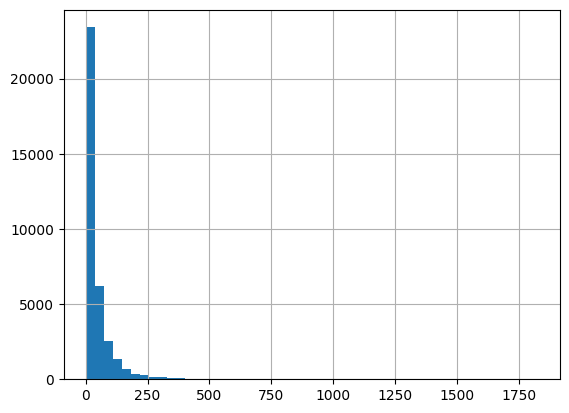

In [13]:
# Distribution of target
train_df.biomass.hist(bins = 50);

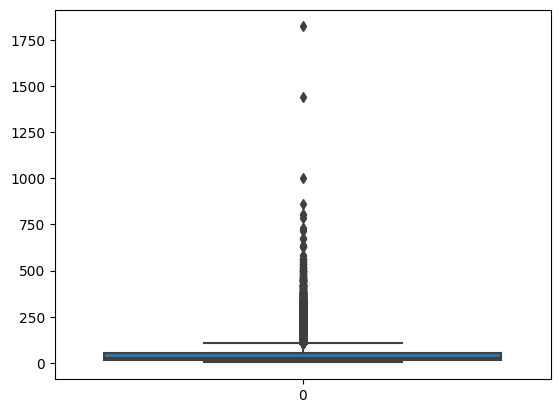

In [14]:
# Distribution of target
sns.boxplot(train_df.biomass);

In [15]:
# Drop outliers - Retain targets between 20 and 300
train_df = train_df[(train_df.biomass > 20) & (train_df.biomass < 300)].reset_index(drop = True)
train_df.shape

(21877, 3601)

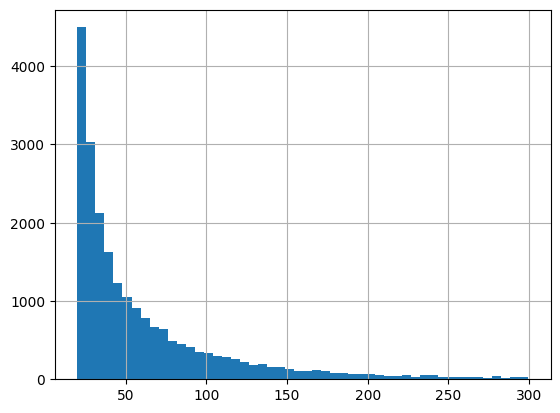

In [16]:
# Distribution of target after dropping outliers
train_df.biomass.hist(bins = 50);

In [17]:
spyndex.indices["NDVI"]

SpectralIndex(NDVI: Normalized Difference Vegetation Index)
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R']
        * Formula: (N-R)/(N+R)
        * Reference: https://ntrs.nasa.gov/citations/19740022614
        

In [18]:
# Function to calculate vegetation indices
def calculate_idxs(df, idxs):
  def band_cols_generator(band):
    return [band + '_' + str(i) for i in range(225)]

  idx_contants = {}
  for x in spyndex.constants:
    try:
      idx_contants = idx_contants | {x: float(str(getattr(spyndex.constants, x)).strip().split(':')[-1].strip())}
    except:
      pass

  veg_idxs = spyndex.computeIndex(
      index = idxs,
      params = {
        'A': df[band_cols_generator('B1')].mean(axis = 1), 
        'B': df[band_cols_generator('B2')].mean(axis = 1), 
        'G': df[band_cols_generator('B3')].mean(axis = 1), 
        'R': df[band_cols_generator('B4')].mean(axis = 1), 
        'RE1' : df[band_cols_generator('B5')].mean(axis = 1), 
        'RE2': df[band_cols_generator('B6')].mean(axis = 1), 
        'RE3': df[band_cols_generator('B7')].mean(axis = 1), 
        'N': df[band_cols_generator('B8')].mean(axis = 1), 
        'N2': df[band_cols_generator('B9')].mean(axis = 1), 
        'WV': df[band_cols_generator('B10')].mean(axis = 1), 
        'S1': df[band_cols_generator('B11')].mean(axis = 1), 
        'S2': df[band_cols_generator('B12')].mean(axis = 1)} | idx_contants
    )

  return veg_idxs

In [19]:
# get a list of vegetation indices
veg_idxs = []
for veg_idx in spyndex.indices:
  try: 
    calculate_idxs(test_df.iloc[:5, :],[veg_idx])
    veg_idxs.append(veg_idx)
  except:
    pass
random.sample(veg_idxs, 5)

['GLI', 'AWEInsh', 'CSI', 'S2WI', 'OCVI']

In [20]:
# Calculate vegetation indices for train and test
train_idxs_df = calculate_idxs(train_df,veg_idxs)
test_idxs_df = calculate_idxs(test_df,veg_idxs)
train_idxs_df['target'] = train_df.biomass
train_idxs_df.head()

,AFRI1600,AFRI2100,ANDWI,ARI,ARI2,ARVI,ATSAVI,AVI,AWEInsh,AWEIsh,BAI,BAIM,BAIS2,BCC,BI,BITM,BIXS,BLFEI,BNDVI,BRBA,BWDRVI,BaI,CIG,CIRE,CSI,CVI,DBSI,DSI,DSWI1,DSWI2,DSWI3,DSWI4,DSWI5,DVI,EMBI,EVI,EVI2,ExG,ExGR,ExR,FCVI,GARI,GBNDVI,GCC,GDVI,GEMI,GLI,GM1,GM2,GNDVI,GOSAVI,GRNDVI,GRVI,GSAVI,GVMI,IAVI,IBI,IKAW,IPVI,IRECI,LSWI,MBI,MBWI,MCARI,MCARI1,MCARI2,MCARI705,MCARIOSAVI,MCARIOSAVI705,MGRVI,MIRBI,MLSWI26,MLSWI27,MNDVI,MNDWI,MNLI,MRBVI,MSAVI,MSI,MSR,MSR705,MTCI,MTVI1,MTVI2,MuWIR,NBAI,NBR,NBR2,NBRSWIR,NBRplus,NBSIMS,ND705,NDBI,NDCI,NDDI,NDGlaI,NDII,NDMI,NDPI,NDPonI,NDREI,NDSI,NDSII,NDSInw,NDSWIR,NDSaII,NDSoI,NDTI,NDVI,NDVI705,NDVIMNDWI,NDWI,NDWIns,NDYI,NGRDI,NHFD,NIRv,NLI,NMDI,NRFIg,NRFIr,NSDS,NSDSI1,NSDSI2,NSDSI3,NWI,NormG,NormNIR,NormR,OCVI,OSAVI,PISI,PSRI,RCC,RDVI,REDSI,RENDVI,RGBVI,RGRI,RI,RI4XS,RVI,S2REP,S2WI,S3,SARVI,SAVI,SAVI2,SEVI,SI,SIPI,SR,SR2,SR3,SR555,SR705,SWI,SWM,SeLI,TCARI,TCARIOSAVI,TCARIOSAVI705,TCI,TDVI,TGI,TRRVI,TSAVI,TTVI,TVI,TWI,TriVI,UI,VARI,VARI700,VI700,VIBI,VIG,VgNIRBI,VrNIRBI,WDRVI,WDVI,WI1,WI2,WI2015,WRI,mND705,mSR705,target
0,0.488623,0.789498,-0.703536,0.000754,2.601841,0.853081,0.849680,NaN,-3814.515556,-6551.588889,8.335441e-08,6.593657e+05,486861.867975,0.259478,-0.284082,367.087354,405.795004,-0.543716,0.853081,0.156097,0.115550,-1374.946667,5.895578,3.293737,4.250553,3.863211,-0.285534,0.520490,1.921268,3.589078,6.406268,1.784934,1.902860,3171.862222,0.152694,2.571684,1.921624,447.115556,583.136444,-136.020889,3100.731852,0.995418,0.633581,0.474619,0.986884,-1.005619e+07,0.287436,5.539224,3.449163,0.746694,0.746663,0.630966,6.895578,1.493010,0.619089,0.846364,-3.502588,0.012230,0.924858,11137.775158,0.315366,0.092896,-5340.653333,1326.847237,4910.945067,0.889121,5224.487930,1346.193982,8182.119657,0.522216,-9485.639111,3.172234,1.615513,0.619088,-0.564183,1.999906,0.024456,0.918742,0.520490,3.099794,1.161124,3.761305,4910.945067,0.889121,-0.231535,-0.377407,0.619088,0.377407,-0.377400,-0.696292,-275.020541,0.550477,-0.315366,0.482741,15.495733,0.281850,0.315366,0.315366,0.354495,0.564183,0.622195,-0.564183,-0.746694,0.315356,0.315366,-0.729958,0.237304,-0.281850,0.849716,0.550477,1.413899,-0.746694,0.039318,0.293070,0.281850,0.628800,2933.522489,0.999953,0.556146,-0.237304,-0.486608,0.377407,0.547996,1.212369,0.377407,-0.913589,0.118262,0.815483,0.066255,3.521185,0.849680,-1755.623128,0.002444,0.265903,51.915150,120.120407,0.550477,0.531054,0.560245,-0.281850,1.252177e-06,9.887151,724.390971,-0.005054,-0.267175,1.705704,1.698977,12.308155,12.310227,NaN,1.030661,12.308155,6.895578,0.009345,5.539224,3.449163,0.039942,0.147521,0.647821,1048.859562,1064.152972,1886.425389,923.205624,1.378113,21322.711111,0.441309,0.849716,24762.293333,1.161773,-4.981810,199118.488889,-0.619088,0.433882,0.638252,0.482741,1.590185,0.281850,-0.746694,-0.849716,0.103467,3171.862222,-0.237304,-0.495887,-293736.795156,0.148812,0.580196,0.876043,99.101875
1,0.421407,0.717022,-0.624502,0.000556,1.805768,0.777404,0.770143,NaN,-3352.302222,-6160.797778,9.306957e-08,1.147631e+06,313095.113127,0.278369,-0.202292,498.314978,538.153144,-0.477528,0.777404,0.210507,-0.112046,-823.782222,4.132746,2.326977,3.033847,3.420402,-0.250296,0.616752,1.621398,3.165630,4.750429,1.500627,1.600396,2828.653333,0.137923,2.589741,1.658221,437.502222,522.174667,-84.672444,2763.202963,0.988654,0.515078,0.433051,0.966847,-7.997360e+06,0.208752,4.169287,2.702476,0.673882,0.673854,0.509823,5.132746,1.347417,0.504200,0.763008,-2.736754,0.018010,0.885088,7873.669483,0.237048,0.133747,-5482.431111,1125.798211,4402.864533,0.846588,3410.531768,1260.175858,6394.323259,0.384971,-8930.981333,4.221136,1.983809,0.504195,-0.519881,1.999840,0.036009,0.870152,0.616752,2.271999,0.884779,2.997021,4402.864533,0.846588,-0.472196,-0.303410,0.504195,0.303410,-0.303407,-0.625378,-457.024947,0.459821,-0.237048,0.396703,14.996222,0.200200,0.237048,0.237048,0.275462,0.519881,0.537784,-0.519881,-0.673882,0.237039,0.237048,-0.652200,0.257010,-0.200200,0.770177,0.459821,1.290057,-0

In [21]:
train_idxs_df.shape, test_idxs_df.shape

((21877, 188), (90, 187))

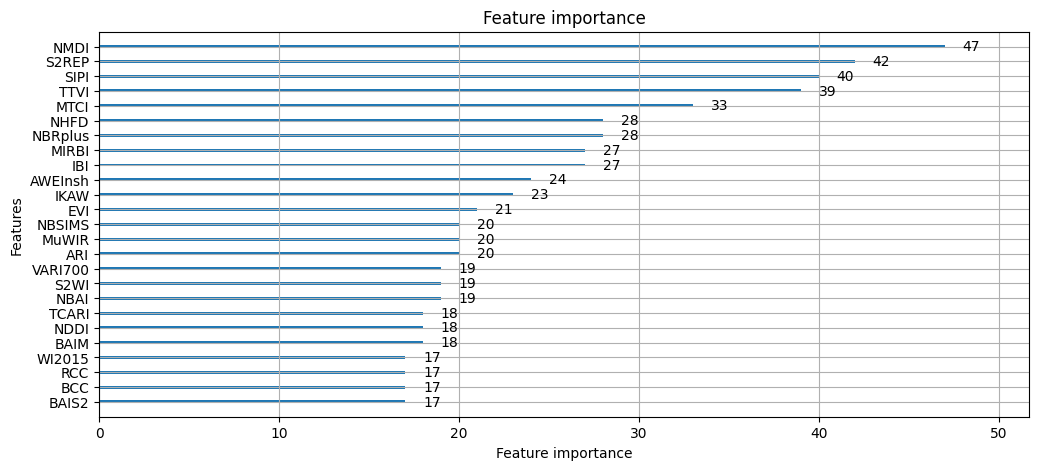

In [22]:
# Split data to training and validation datasets
X = train_idxs_df.copy()

folds = KFold(n_splits = 25, shuffle = True, random_state = 42)
X['fold'] = 0
for i,( _, test_index) in enumerate(folds.split(X)):
  X.loc[test_index, 'fold'] = i

X_train, X_test = X[X.fold != 5].drop(['target', 'fold'], axis = 1),  X[X.fold == 5].drop(['target', 'fold'], axis =1)
y_train, y_test = X[X.fold != 5].target,  X[X.fold == 5].target

# Instantiate model
model = model = LGBMRegressor(n_estimators=2000, objective = 'quantile')

# Train model
model.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=200,
            verbose = 0)

# Make predictions
preds = model.predict(test_idxs_df)

# Check top 25 features
lightgbm.plot_importance(model, max_num_features=25, figsize = (12,5));

In [23]:
# Prepare subfile
preds_df = pd.DataFrame({'Target':preds}).rename_axis('S2_idx').reset_index()
preds_df = ID_S2_pair.merge(preds_df, on='S2_idx').drop(columns=['S2_idx'])
preds_df.to_csv('final_sub.csv', index = False)
preds_df.head()

,ID,Target
0,ID_1EB0DGFP07,87.343501
1,ID_844T2PSXTK,87.045348
2,ID_4MCV3S8MLN,85.436561
3,ID_L7441JV5F3,95.393066
4,ID_5GUVM4YEWZ,130.988277
